# Infer EC50 values for the BIOFAB's *second* replicate of the `Inna April 2016` chip

## Import `Python` modules

In [13]:
import os
import sys
import re
import glob

import xml.etree.ElementTree as ET
sys.path.append("/home/jupyter/tacc-work/jupyter_packages/lib/python2.7/site-packages")
from FlowCytometryTools import *

import numpy as np
import scipy.stats
import pandas
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=1.5)

# Initialize directories
resultsdir = "results/Inna_April_2016_rep2"
resultsdir_parse_metadata = os.path.join(resultsdir, 'parse_metadata')
dirs = [resultsdir, resultsdir_parse_metadata]
for dir_i in dirs:
    if not os.path.isdir(dir_i):
        os.makedirs(dir_i)

## Make the input experimental-summary file

### Specify all inputs

In [2]:
# Specify the location of FASTQ files
fastq_dir = '/work/05402/haddox/jupyter/sd2e-community/shared-q1-workshop/strcklnd/ngs_data/run_5/Inna/'
fastq_summary_file = '/work/05402/haddox/jupyter/sd2e-community/shared-q1-workshop/strcklnd/ngs_data/run_5/manifest.csv'

# Specify the locations of directories with FCS files with part of the FACS data
facs_dir = "/work/05402/haddox/jupyter/sd2e-community/shared-q1-workshop/strcklnd/facs_data/production_data/"
job_ids = ['Job_56649', 'Job_56497', 'Job_56243']
facs_dirs = ','.join([os.path.join(facs_dir, job_id) for job_id in job_ids])
job_ids = ','.join(job_ids)

# Specify the FACS channel name to investigate
facs_channel_name = u'FITC-A'

# Make a list of input XML files with the other part of the FACS data
xml_files = ','.join(glob.glob(
    os.path.join(facs_dir, 'sort_reports', '*/*.xml')
))

# Specify column-specific values to analyze in the metadata files.
library_name = "Inna_April_2016"
ignore_aq_item_ids = '123565'

# Specify the output metadata CSV file
experimental_metadata_output_file = os.path.join(resultsdir_parse_metadata, 'experimental_metadata_from_script.csv')

# Read in input arguments, as if it were a new script
job_ids = job_ids.split(',')
facs_dirs = facs_dirs.split(',')
xml_files = xml_files.split(',')
ignore_aq_item_ids = ignore_aq_item_ids.split(',')

# Read in data on location of deep-sequencing data
fastq_df = pandas.read_csv(fastq_summary_file)

# Remove entires to ignore 
indices_to_drop = [i for (i, row) in fastq_df.iterrows() if str(row['aq_item_id']) in ignore_aq_item_ids]
fastq_df.drop(indices_to_drop, inplace=True)

# Piece together paths to FASTQ files and tweak some of entries to match
# expected patterns/cases
fastq_df['filename_prefix'] = fastq_df['filename_prefix'].apply(lambda x: x.replace('_', '-'))
fastq_df['fastq_id'] = fastq_df.apply(lambda row: os.path.join(
    str(row['aq_item_id']), 'Files', row['filename_prefix']
), axis=1)
fastq_df['protease'] = fastq_df['protease'].apply(lambda x: x.lower())
fastq_df['strain'] = fastq_df['strain'].apply(lambda x: x.replace(' ', '_'))

# To conform with previous naming schemes, I will relabel the
# naive sample (naive, 0) to be the naive trypsin sample (trypsin, 0)
fastq_df['protease'] = fastq_df['protease'].apply(lambda x: x.replace('naive', 'trypsin'))

# Index by protease name and concentration
fastq_df.set_index(['protease', 'concentration'], inplace=True)

# Downsample to include only samples within library of interest
fastq_df = fastq_df[fastq_df['strain']==library_name]
fastq_df.sort_index()

aq_item_id                      filename_prefix  \
protease     concentration                                                    
chymotrypsin 9.5                123567     123567-Inna-april-Chymotrypsin-9   
             28.0               123569    123569-Inna-april-Chymotrypsin-28   
             83.0               123576    123576-Inna-april-Chymotrypsin-83   
             250.0              123577   123577-Inna-april-Chymotrypsin-250   
             750.0              123573   123573-Inna-april-Chymotrypsin-750   
             2250.0             123572  123572-Inna-april-Chymotrypsin-2250   
trypsin      0.0                123578              123579-Inna-april-naive   
             9.5                123568          123568-Inna-april-Trypsin-9   
             28.0               123566         123566-Inna-april-Trypsin-28   
             83.0               123574         123574-Inna-april-Trypsin-83   
             250.0              123575        123575-Inna-april-Trypsin-250   
             750.0              123570        123570-Inna-april-Trypsin-750   
             2250.0             123571       123571-Inna-april-Trypsin-2250   

                                     strain  \
protease     concentration                    
chymotrypsin 9.5            Inna_April_2016   
             28.0           Inna_April_2016   
             83.0           Inna_April_2016   
             250.0          Inna_April_2016   
             750.0          Inna_April_2016   
             2250.0         Inna_April_2016   
trypsin      0.0            Inna_April_2016   
             9.5            Inna_April_2016   
             28.0           Inna_April_2016   
             83.0           Inna_April_2016   
             250.0          Inna_April_2016   
             750.0          Inna_April_2016   
             2250.0         Inna_April_2016   

                                                                    fastq_id  
protease     concentration                                                    
chymotrypsin 9.5               123567/Files/123567-Inna-april-Chymotrypsin-9  
             28.0             123569/Files/123569-Inna-april-Chymotrypsin-28  
             83.0             123576/Files/123576-Inna-april-Chymotrypsin-83  
             250.0           123577/Files/123577-Inna-april-Chymotrypsin-250  
             750.0           123573/Files/123573-Inna-april-Chymotrypsin-750  
             2250.0         123572/Files/123572-Inna-april-Chymotrypsin-2250  
trypsin      0.0                        123578/Files/123579-Inna-april-naive  
             9.5                    123568/Files/123568-Inna-april-Trypsin-9  
             28.0                  123566/Files/123566-Inna-april-Trypsin-28  
             83.0                  123574/Files/123574-Inna-april-Trypsin-83  
             250.0                123575/Files/123575-Inna-april-Trypsin-250  
             750.0                123570/Files/123570-Inna-april-Trypsin-750  
             2250.0              123571/Files/123571-Inna-april-Trypsin-2250

### For each sample in the experiment, quantify the total number of events and the number of events that passed the sorting threshold

In [3]:
def s_log(sample, channel_names):
    new_sample = sample.copy()
    new_data = new_sample.data

    for channel_name in channel_names:
        new_data[channel_name] = np.log10(new_data[channel_name])
        
    new_data.replace(to_replace = -np.inf, value = -1, inplace = True)
    new_data = new_data.dropna()
    new_sample.data = new_data
    
    return new_sample

In [4]:
# Read in data from the `manifest.txt` files
manifest_df = pandas.DataFrame()
for (job_id, facs_dir) in zip(job_ids, facs_dirs):
    df = pandas.read_csv(os.path.join(facs_dir, 'manifest.txt'))
    df['job_id'] = job_id
    df['directory'] = facs_dir
    df['specimen'] = df['filename'].apply(lambda x : x[:12])
    df['tube'] = df['filename'].apply(lambda x : x[13:21])
    df['strain'] = df['strain'].apply(lambda x: x.replace(' ', '_'))
    manifest_df = pandas.concat([manifest_df, df])
manifest_df.set_index(['job_id', 'specimen', 'tube'], inplace=True)

In [5]:
# Quantify the total number of events and events passing the gate
fitc_data_dict = {}
total_number_of_recorded_events = []
number_of_events_passing_fitc_gate = []
for (i, row) in manifest_df.iterrows():
    
    # Read in the data for the appropriate channel and transform it to a log10 scale
    fcs_file = os.path.join(row['directory'], row['filename'])
    sample = FCMeasurement(ID='Test Sample', datafile=fcs_file)
    #print("Analyzing the channel: {0}".format(channel_name))
    sample = s_log(sample, [facs_channel_name])
    df = sample.data
    
    # Count the number of total events and events passing the gate
    total_number_of_recorded_events.append(len(df.index.values))
    number_of_events_passing_fitc_gate.append(
        sum(df[facs_channel_name] > 3.0)
    )

# Append the FACS data to the manifest dataframe
manifest_df['total_number_of_recorded_events'] = total_number_of_recorded_events
manifest_df['number_of_events_passing_fitc_gate'] = number_of_events_passing_fitc_gate
manifest_df['fraction_collected'] = \
    manifest_df['number_of_events_passing_fitc_gate'] / manifest_df['total_number_of_recorded_events']
columns_to_show = [
    'strain', 'protease', 'concentration', 'total_number_of_recorded_events',
    'number_of_events_passing_fitc_gate', 'fraction_collected'
]
#manifest_df[columns_to_show]

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log10
/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10


Read in data from the XML files on the total number of cells collected. I will do this for all XML files the BIOFAB has uploaded, even ones that aren't relevant to this experiment. Then, I will identify the relevant ones using the `job_id`, `specimen`, and `tube` columns.

In [6]:
# Compile data in each XML file
xml_data_dict = {
    key : []
    for key in ['job_id', 'specimen', 'tube', 'cells_collected', 'intended_number_of_cells_collected'] #
}
cells_collected_pattern = re.compile(r'\w+ : (?P<cells_collected>\d+) / (?P<intended_number_of_cells_collected>\d+)')
for filename in xml_files:
    tree = ET.parse(filename)
    root = tree.getroot()

    # Get experiment metadata
    xml_data_dict['job_id'].append( root.findall(".//*[@name='Experiment']")[0].get('value') )
    xml_data_dict['specimen'].append( root.findall(".//*[@name='Specimen']")[0].get('value') )
    xml_data_dict['tube'].append( root.findall(".//*[@name='Tube']")[0].get('value') )
    
    # Get experiment counts
    cells_collected_data = root[4].findall(".//*[@col='1']")[0].text
    match = re.match(cells_collected_pattern, cells_collected_data)
    if match:
        xml_data_dict['cells_collected'].append(
            int(match.group('cells_collected'))
        )
        xml_data_dict['intended_number_of_cells_collected'].append(
            int(match.group('intended_number_of_cells_collected'))
        )
    else:
        xml_data_dict['cells_collected'].append(None)
        xml_data_dict['intended_number_of_cells_collected'].append(None)
          
# Convert data to a dataframe
xml_data_df = pandas.DataFrame.from_dict(xml_data_dict)
xml_data_df.set_index(['job_id', 'specimen', 'tube'], inplace=True)
#xml_data_df

Merge the FACS data from the two input sources

In [7]:
facs_df = manifest_df.merge(xml_data_df, left_index=True, right_index=True, how='left')
facs_df = facs_df[
    facs_df['strain'] == library_name
]
facs_df.set_index(['protease', 'concentration'], inplace=True)
columns_to_show = ['cells_collected', 'fraction_collected']
facs_df[columns_to_show].sort_index()

cells_collected  fraction_collected
protease     concentration                                     
chymotrypsin 9.5                  1200000.0            0.189052
             28.0                 1200000.0            0.174285
             83.0                 5641051.0            0.636093
             250.0                5631873.0            0.505090
             750.0                2564592.0            0.305309
             2250.0               1127664.0            0.128904
trypsin      0.0                  1200000.0            0.208038
             9.5                  1200000.0            0.182106
             28.0                 1200000.0            0.166087
             83.0                 7560000.0            0.628806
             250.0                5667250.0            0.495755
             750.0                 895311.0            0.139653
             2250.0                267584.0            0.032190

Merge the FACS and deep-sequencing data

In [8]:
df = fastq_df.merge(facs_df, left_index=True, right_index=True, how="outer")
columns_to_write = ['fastq_id', 'cells_collected', 'fraction_collected']
df = df[columns_to_write]
df.reset_index(inplace=True)
df

,protease,concentration,fastq_id,cells_collected,fraction_collected
0,chymotrypsin,9.5,123567/Files/123567-Inna-april-Chymotrypsin-9,1200000.0,0.189052
1,chymotrypsin,28.0,123569/Files/123569-Inna-april-Chymotrypsin-28,1200000.0,0.174285
2,chymotrypsin,83.0,123576/Files/123576-Inna-april-Chymotrypsin-83,5641051.0,0.636093
3,chymotrypsin,250.0,123577/Files/123577-Inna-april-Chymotrypsin-250,5631873.0,0.505090
4,chymotrypsin,750.0,123573/Files/123573-Inna-april-Chymotrypsin-750,2564592.0,0.305309
5,chymotrypsin,2250.0,123572/Files/123572-Inna-april-Chymotrypsin-2250,1127664.0,0.128904
6,trypsin,0.0,123578/Files/123579-Inna-april-naive,1200000.0,0.208038
7,trypsin,9.5,123568/Files/123568-Inna-april-Trypsin-9,1200000.0,0.182106
8,trypsin,28.0,123566/Files/123566-Inna-april-Trypsin-28,1200000.0,0.166087
9,trypsin,83.0,123574/Files/123574-Inna-april-Trypsin-83,7560000.0,0.628806


Add a row for a naive sample for chymotrypsin, using the same deep-sequencing data as for trypsin 

In [9]:
df_with_extra_row = pandas.DataFrame.from_dict(
    {
        'protease' : ['chymotrypsin'],
        'concentration' : [0],
        'fastq_id' : [df.iloc[6]['fastq_id']],
        'cells_collected' : [df.iloc[6]['cells_collected']],
        'fraction_collected' : [df.iloc[6]['fraction_collected']]
    }
)
df_with_extra_row
df = pandas.concat([df, df_with_extra_row])

Show concatenated dataframe, sorted by protease and protease concentration.

In [10]:
df.sort_values(by=['protease', 'concentration'], inplace=True)
df

,cells_collected,concentration,fastq_id,fraction_collected,protease
0,1200000.0,0.0,123578/Files/123579-Inna-april-naive,0.208038,chymotrypsin
0,1200000.0,9.5,123567/Files/123567-Inna-april-Chymotrypsin-9,0.189052,chymotrypsin
1,1200000.0,28.0,123569/Files/123569-Inna-april-Chymotrypsin-28,0.174285,chymotrypsin
2,5641051.0,83.0,123576/Files/123576-Inna-april-Chymotrypsin-83,0.636093,chymotrypsin
3,5631873.0,250.0,123577/Files/123577-Inna-april-Chymotrypsin-250,0.505090,chymotrypsin
4,2564592.0,750.0,123573/Files/123573-Inna-april-Chymotrypsin-750,0.305309,chymotrypsin
5,1127664.0,2250.0,123572/Files/123572-Inna-april-Chymotrypsin-2250,0.128904,chymotrypsin
6,1200000.0,0.0,123578/Files/123579-Inna-april-naive,0.208038,trypsin
7,1200000.0,9.5,123568/Files/123568-Inna-april-Trypsin-9,0.182106,trypsin
8,1200000.0,28.0,123566/Files/123566-Inna-april-Trypsin-28,0.166087,trypsin


Manually add missing columns

In [11]:
# Add columns
df['experiment_id'] = 'Inna_April_2016_rep2'
df['selection_strength'] = 2 * [i for i in range(0,7)]
df['conc_factor'] = 2 * ['', '3', '3', '3', '3', '3', '3']
df['parent'] = 2 * ['', '0', '0', '2', '2', '4', '4']
df['parent_expression'] = 2 * ['', 0.208038, 0.208038, '', '', '', '']

# Rename columns
df.rename(
    {'protease':'protease_type'},
    inplace=True,
    axis='columns'
)
column_order = [
    'experiment_id', 'protease_type', 'concentration', 'selection_strength', 'parent', 'conc_factor', 'fastq_id',
    'parent_expression', 'fraction_collected', 'cells_collected'
]
df[column_order]

,experiment_id,protease_type,concentration,selection_strength,parent,conc_factor,fastq_id,parent_expression,fraction_collected,cells_collected
0,Inna_April_2016_rep2,chymotrypsin,0.0,0,,,123578/Files/123579-Inna-april-naive,,0.208038,1200000.0
0,Inna_April_2016_rep2,chymotrypsin,9.5,1,0,3,123567/Files/123567-Inna-april-Chymotrypsin-9,0.208038,0.189052,1200000.0
1,Inna_April_2016_rep2,chymotrypsin,28.0,2,0,3,123569/Files/123569-Inna-april-Chymotrypsin-28,0.208038,0.174285,1200000.0
2,Inna_April_2016_rep2,chymotrypsin,83.0,3,2,3,123576/Files/123576-Inna-april-Chymotrypsin-83,,0.636093,5641051.0
3,Inna_April_2016_rep2,chymotrypsin,250.0,4,2,3,123577/Files/123577-Inna-april-Chymotrypsin-250,,0.505090,5631873.0
4,Inna_April_2016_rep2,chymotrypsin,750.0,5,4,3,123573/Files/123573-Inna-april-Chymotrypsin-750,,0.305309,2564592.0
5,Inna_April_2016_rep2,chymotrypsin,2250.0,6,4,3,123572/Files/123572-Inna-april-Chymotrypsin-2250,,0.128904,1127664.0
6,Inna_April_2016_rep2,trypsin,0.0,0,,,123578/Files/123579-Inna-april-naive,,0.208038,1200000.0
7,Inna_April_2016_rep2,trypsin,9.5,1,0,3,123568/Files/123568-Inna-april-Trypsin-9,0.208038,0.182106,1200000.0
8,Inna_April_2016_rep2,trypsin,28.0,2,0,3,123566/Files/123566-Inna-april-Trypsin-28,0.208038,0.166087,1200000.0


Write the above dataframe to an output file

In [12]:
print("Writing metadata to the experimental summary file: {0}".format(experimental_metadata_output_file))
df[column_order].to_csv(experimental_metadata_output_file, index=False)

Writing metadata to the experimental summary file: results/Inna_April_2016_rep2/parse_metadata/experimental_metadata_from_script.csv


## Compute stability scores from the input deep-sequencing and FACS data

In [13]:
# Define input variables
data_dir = 'data/160401_chip/'
designed_sequences_file = os.path.join(data_dir, 'designed_protein_sequences.csv')
experimental_summary_file = os.path.join(experimental_metadata_output_file)
fastq_dir = fastq_dir
pear_path = '/home/05402/haddox/software/pear/bin/pear'
output_dir = resultsdir

In [14]:
# Write the command to carry everything out
cmd = ' '.join([
    'python',
    'scripts/compute_ec50_values_from_deep_sequencing_data.py',
    '--designed_sequences_file {0}'.format(designed_sequences_file),
    '--experimental_summary_file {0}'.format(experimental_summary_file),
    '--fastq_dir {0}'.format(fastq_dir),
    '--pear_path {0}'.format(pear_path),
    '--output_dir {0}'.format(output_dir)
])

#! {cmd}
print(cmd)

python scripts/compute_ec50_values_from_deep_sequencing_data.py --designed_sequences_file data/160401_chip/designed_protein_sequences.csv --experimental_summary_file results/Inna_April_2016_rep2/parse_metadata/experimental_metadata_from_script.csv --fastq_dir /work/05402/haddox/jupyter/sd2e-community/shared-q1-workshop/strcklnd/ngs_data/run_5/Inna/ --pear_path /home/05402/haddox/software/pear/bin/pear --output_dir results/Inna_April_2016_rep2


Read in the stability scores for each protease and make a single dataframe with data from each, with suffixes of `_t` or `_c` indicating that the data is derived from trypsin or chymotrypsin, respectively.

In [26]:
# Read in data for each protease, making the `name` column the index
# in each case
trypsin_df = pandas.read_csv(
    os.path.join(resultsdir, 'stability_scores/trypsin_stability_scores.txt'), sep='\t'
)
chymotrypsin_df = pandas.read_csv(
    os.path.join(resultsdir, 'stability_scores/chymotrypsin_stability_scores.txt'), sep='\t'
)
trypsin_df.set_index('name', inplace=True)
chymotrypsin_df.set_index('name', inplace=True)

# Merge the dataframes, using `_t` and `_c` as suffixes to indicate
# which data is from trypsin and chymotrypsin, respectively
stability_scores_df = trypsin_df.merge(
    chymotrypsin_df,
    left_index=True,
    right_index=True,
    how='outer',
    suffixes=['_t', '_c']
)
stability_scores_df['stabilityscore'] = stability_scores_df.apply(
    lambda row: min(row['stabilityscore_t'], row['stabilityscore_c']), axis=1
)
stability_scores_outfile = os.path.join(resultsdir, 'stability_scores/stability_scores.txt')
print("Writing merged stability scores to the file: {0}".format(stability_scores_outfile))
stability_scores_df.to_csv(stability_scores_outfile, sep='\t')

Writing merged stability scores to the file: results/Inna_April_2016_rep2/stability_scores/stability_scores.txt


Look at the correlation between the stability scores for trypsin and chymotrypsin.

0.833613165981


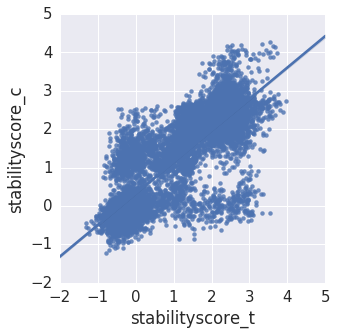

In [27]:
print(stability_scores_df['stabilityscore_t'].corr(stability_scores_df['stabilityscore_c']))
sns.lmplot(x='stabilityscore_t', y='stabilityscore_c', data=stability_scores_df)

Look at the distribution of stability scores for trypsin and chymotrypsin.

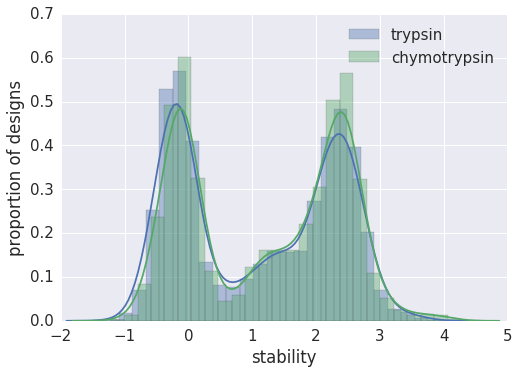

In [29]:
sns.distplot(stability_scores_df['stabilityscore_t'], label='trypsin')
sns.distplot(stability_scores_df['stabilityscore_c'], label='chymotrypsin')
plt.ylabel('proportion of designs')
plt.xlabel('stability')
plt.legend()
plt.show()

## To do:

* Quantify sequencing depth
* Look at the distribution of counts over time

Quantify the number of assembled reads per sample

In [ ]:
def ParsePAREOutfile(outfile):
    """
    This function parses the output data generated by PARE when assemblying paired-end reads
    
    Args:
        `outfile`: the path to a file with the output data generated by PARE
        
    Returns:
        A tupple with the following three variables in the order they appear in the below list:
            `n_assembled_reads` : the total number of assembled reads
            `n_discarded_reads` : the total number of discarded reads
            `n_non_assembled_reads` : the total number of non_assembled_reads
    """
    
    # Pattern used to extract data
    n_reads_pattern = re.compile(r'\: (?P<n_reads>[\d,]+) /')
    
    # Use regular expressions to extract the relevant info from the file
    n_assembled_reads = n_discarded_reads = n_non_assembled_reads = n_total_reads = None
    with open(outfile) as f:
        #print(f.readlines())
        for line in f:
            if 'Assembled reads .' in line:
                if n_assembled_reads:
                    raise ValueError("Already found data for `n_assembled_reads`")
                n_assembled_match = re.search(n_reads_pattern, line)
                n_assembled_reads = int(n_assembled_match.group('n_reads').replace(',', ''))
                
            elif 'Discarded reads .' in line:
                if n_discarded_reads:
                    raise ValueError("Already found data for `n_discarded_reads`")
                n_discarded_match = re.search(n_reads_pattern, line)
                n_discarded_reads = int(n_discarded_match.group('n_reads').replace(',', ''))
                
            elif 'Not assembled reads .' in line:
                if n_non_assembled_reads:
                    raise ValueError("Already found data for `n_non_assembled_reads`")
                n_non_assembled_match = re.search(n_reads_pattern, line)
                n_non_assembled_reads = int(n_non_assembled_match.group('n_reads').replace(',', ''))
    
    return (n_assembled_reads, n_discarded_reads, n_non_assembled_reads)


In [ ]:
# Find log files from PARE
pare_log_dir = os.path.join(resultsdir, 'paired_FASTQ_files')

selection_indices = list(range(0,7))
experiment_names = ['trypsin_{0}'.format(i) for i in selection_indices] + \
    ['chymotrypsin_{0}'.format(i) for i in selection_indices]
log_files = glob.glob(os.path.join(pare_log_dir, '*.log'))
log_files_dict = {
    experiment_name : []
    for experiment_name in experiment_names
}
# For each log file, look for an experimental name that matches the beginning
# of the base name of the log file
for log_file_name in log_files:
    matching_experiments = []
    for experiment_name in log_files_dict:
        log_file_basename = os.path.basename(log_file_name)
        if log_file_basename.find('{0}-'.format(experiment_name)) == 0:
            log_files_dict[experiment_name].append(log_file_name)
            matching_experiments.append(experiment_name)
    if len(matching_experiments) == 0:
        raise ValueError("Could not find a matching experiment for the log file: {0}".format(log_file_name))
    if len(matching_experiments) > 1:
        print(matching_experiments)
        raise ValueError("Found multiple matching experiments for the log file: {0}".format(log_file_name))
    assert len(matching_experiments) == 1

In [ ]:
# Read in depth and quality scores from the output of the `PEAR` program and store in a pandas dataframe
assembly_d = {
    key : []
    for key in ['experiment_name', 'n_assembled_reads', 'n_discarded_reads', 'n_non_assembled_reads']
}
for experiment_name in log_files_dict:
    assembly_d['experiment_name'].append(experiment_name)
    n_assembled_reads = n_discarded_reads = n_non_assembled_reads = 0
    for log_file_name in log_files_dict[experiment_name]:
        (n_assembled_reads_i, n_discarded_reads_i, n_non_assembled_reads_i) = \
            ParsePAREOutfile(log_file_name)
        n_assembled_reads += n_assembled_reads_i
        n_discarded_reads += n_discarded_reads_i
        n_non_assembled_reads += n_non_assembled_reads_i
    assembly_d['n_assembled_reads'].append(n_assembled_reads)
    assembly_d['n_discarded_reads'].append(n_discarded_reads)
    assembly_d['n_non_assembled_reads'].append(n_non_assembled_reads)

assembly_df = pandas.DataFrame.from_dict(assembly_d)

# Plot the data for each replicate as stacked bar charts
fig = plt.figure(figsize=(10,7))

# Get data for each bar
assembly_df.set_index('experiment_name', inplace=True)
labels = sorted(assembly_df.index.values)
first_bar = assembly_df.loc[labels]['n_assembled_reads']
second_bar = assembly_df.loc[labels]['n_non_assembled_reads']
third_bar = assembly_df.loc[labels]['n_discarded_reads']
assert(len(first_bar) == len(second_bar))

# Make plot
plot_indices = np.arange(len(first_bar))
width = 0.35
plt.barh(plot_indices, first_bar, label='assembled', align='center')
plt.barh(plot_indices, second_bar, left=first_bar, label='non-assembled', color='red', align='center')
plt.barh(plot_indices, third_bar, left=second_bar, label='discarded', color='purple', align='center')
plt.yticks(plot_indices, labels)
plt.xlabel('Number of reads')
plt.legend()
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
def adjust_ylim(l):
    mn, mx = l
    mn += 1.5
    mx -= .5
    return (mn, mx)
plt.ylim(adjust_ylim(plt.ylim()))
plt.yticks()

Look at the distribution of stability scores

In [ ]:
trypsin_df = pandas.read_csv('results/Inna_April_2016/stability_scores/trypsin_stability_scores.txt', sep='\t')
chymotrypsin_df = pandas.read_csv('results/Inna_April_2016/stability_scores/chymotrypsin_stability_scores.txt', sep='\t')
sns.distplot(trypsin_df['stabilityscore'])
sns.distplot(chymotrypsin_df['stabilityscore'])
plt.show()

In [ ]:
trypsin_df

## Old code

Old code for making the experimental summary file through a separate script

In [ ]:
# Specify the location of FASTQ files
fastq_dir = '/work/05402/haddox/jupyter/sd2e-community/shared-q1-workshop/strcklnd/ngs_data/run_4'

# Specify the locations of directories with FCS files with part of the FACS data 
facs_dir = "/work/05402/haddox/jupyter/sd2e-community/shared-q1-workshop/strcklnd/facs_data/production_data/"
job_ids = ['Job_56649', 'Job_56497', 'Job_56243']
facs_dirs = ','.join([os.path.join(facs_dir, job_id) for job_id in job_ids])
job_ids = ','.join(job_ids)

# Specify the FACS channel name to investigate
facs_channel_name = u'FITC-A'

# Make a list of input XML files with the other part of the FACS data
xml_files = ','.join(glob.glob(
    os.path.join(facs_dir, 'sort_reports', '*/*.xml')
))

# Specify column-specific values to analyze in the metadata files.
library_name = "Inna_April_2016"
ignore_aq_item_ids = '118852'

# Specify the output metadata CSV file
output_file = os.path.join(resultsdir_parse_metadata, 'experimental_metadata_from_script.csv')

# Carry out the command
cmd = ' '.join([
    'python',
    'scripts/parse_metadata.py',
    '--fastq_dir {0}'.format(fastq_dir),
    "--job_ids {0}".format(job_ids),
    "--facs_dirs {0}".format(facs_dirs),
    "--facs_channel_name {0}".format(facs_channel_name),
    "--xml_files {0}".format(xml_files),
    "--library_name {0}".format(library_name),
    "--ignore_aq_item_ids".format(ignore_aq_item_ids),
    "--output_file {0}".format(output_file)
])

! {cmd}